In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from dispatch.dispatch import Dispatch, NeuralDispatch
from simulator.base_simulator import BaseSimulator, ManualSimulator
from simulator.graphics import plot_CR, plot_counts
from tqdm import tqdm

import torch
from networks.encoders import PointEncoder
from networks.scoring_v1 import ScoringNet, ScoringInterface

from collections import defaultdict
import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector, MultiaSyncDataCollector, MultiSyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from torchrl.envs import EnvBase
from tensordict.tensordict import TensorDictBase, TensorDict
from typing import Optional
import gym
from torchrl.data import CompositeSpec, BoundedTensorSpec, UnboundedContinuousTensorSpec, BinaryDiscreteTensorSpec, OneHotDiscreteTensorSpec, DiscreteTensorSpec, UnboundedDiscreteTensorSpec

# import importlib
# importlib.reload(utils)

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

num_cells = 256  # number of cells in each layer
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 200_000 // frame_skip

sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimisation steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

cpu


In [17]:
net = ScoringNet(
    mode='default',
    # point_encoder=point_encoder,
    n_layers=2,
    d_model=512,
    n_head=4,
    dim_ff=512,
    point_enc_dim=64,
    number_enc_dim=8,
    device=device
)

model = ScoringInterface(net)
model.load_weights('pretrained_models/assignment_cloning_model_v2')

In [22]:
bounds = (Point(0, 0), Point(10, 10))
triples = [random_triple(bounds) for _ in range(16)]

model.encode_input(triples, 0)
preds = model.inference()
mask = model.get_mask()

print(preds.shape, mask.shape)

torch.Size([16, 9, 10]) torch.Size([16, 9, 9])


In [23]:
optimizer = torch.optim.SGD(model.net.parameters(), lr=1e-4, momentum=0.9) # FIX unfreeze encoder params
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs=n_epochs, steps_per_epoch=n_iters)
scheduler = None

losses = []
for epoch in range(10):
    for iter in range(10):
        rolling_loss = []
        triples = [random_triple(bounds) for _ in range(16)]

        scorer = ETAScoring()
        solver = HungarianSolver()
        assignments = []
        for triple in triples:
            scores = scorer(triple.orders, triple.couriers)
            assignments.append([(i, j) for i, j in zip(*solver(scores))])

        # print(assignments)
        # print(50 * '-')

        optimizer.zero_grad()
        model.encode_input(triples, 0)
        model.inference()
        loss = model.CE_loss(assignments)
        loss.backward()
        optimizer.step()
        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))

    print(losses)

[1.5390331745147705]
[1.5390331745147705, 1.0162875652313232]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.0976170301437378]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.0976170301437378, 1.318037748336792]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.0976170301437378, 1.318037748336792, 0.8219321966171265]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.0976170301437378, 1.318037748336792, 0.8219321966171265, 0.9895150661468506]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.0976170301437378, 1.318037748336792, 0.8219321966171265, 0.9895150661468506, 1.0356231927871704]
[1.5390331745147705, 1.0162875652313232, 1.0133600234985352, 0.8432744741439819, 1.097617030143

100%|██████████| 1000/1000 [00:00<00:00, 3918.42it/s]


micro average CR:  0.6660612840478086
macro average CR:  0.6525472836355884


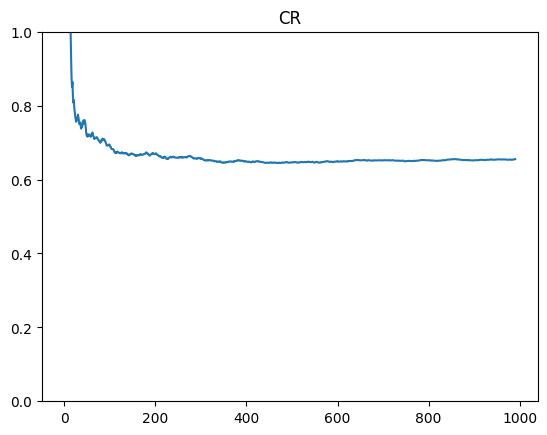

average free couriers:  1.424
average free orders:  14.022
average active routes:  18.576


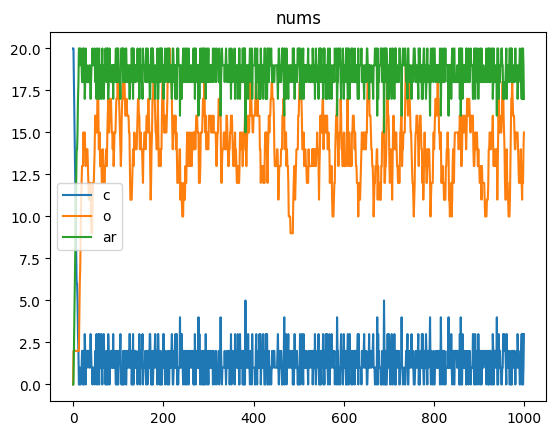

In [3]:
# dsp = NeuralDispatch(net)
dsp = Dispatch()
sim = BaseSimulator(dsp)

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

plot_CR(all_metrics)
plot_counts(all_metrics)

100%|██████████| 1000/1000 [00:00<00:00, 3336.22it/s]


micro average CR:  0.6614969351933401
macro average CR:  0.6485273021964715


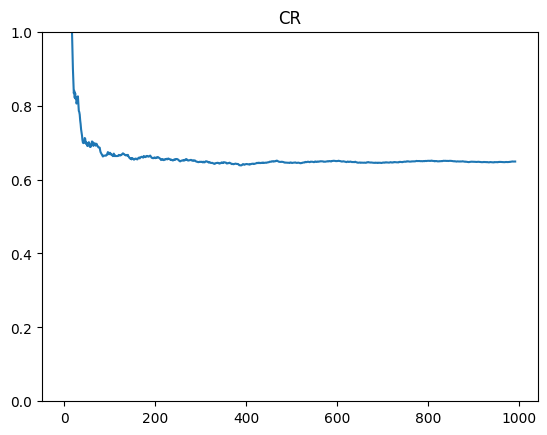

average free couriers:  1.413
average free orders:  14.227
average active routes:  18.587


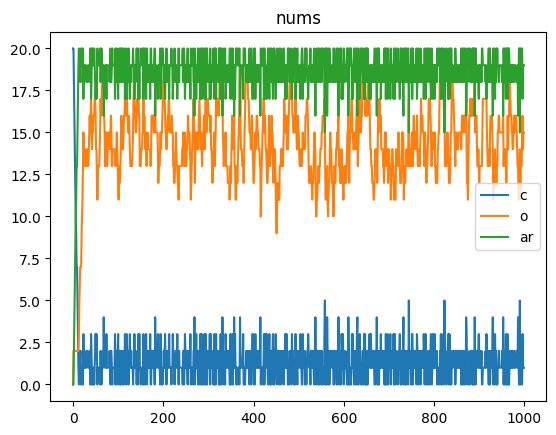

In [26]:
# dsp = NeuralDispatch(net)
dsp = Dispatch()
sim = ManualSimulator()

all_metrics = []
for i in tqdm(range(1000)):
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    ass = dsp(sim.GetState())
    sim.Next(ass)

plot_CR(all_metrics)
plot_counts(all_metrics)

In [53]:
class SimulatorEnv(EnvBase):
    def __init__(self, simulator: ManualSimulator, model: ScoringInterface, seed=None, device="cpu"):
        super().__init__(device=device, batch_size=[])
        self.simulator = simulator
        self.model = model
        # self.simulator.reset()
        self._make_specs()
        
        if seed is None:
            seed = torch.empty((), dtype=torch.long).random_().item()
        self.set_seed(seed)
        
    def _step(self, tensordict: TensorDictBase) -> TensorDictBase:
        '''
        tensordict['action'] - a np.array of indexes of couriers assigned for the given order. If there is no courier assigned -1 is provided.
        '''
        self.simulator.Next([(o_ind, c_ind) for o_ind, c_ind in enumerate(tensordict['action']) if c_ind != -1])
        obs = self.simulator.GetState()
        self.model.encode_input(obs, self.simulator, 0)
        reward = self.simulator.GetReward()
        done = False

        out = TensorDict(
            {
                "next": {
                    "observation": {
                        'orders': self.model.tensors['o'],
                        'couriers': self.model.tensors['c'],
                        'active_routes': self.model.tensors['ar'] 
                    },
                    "reward": torch.tensor(reward, dtype=torch.float32),
                    # "done": torch.tensor(done, dtype=torch.bool),
                }
            },
            batch_size=tensordict.shape[0]
            # tensordict.shape,
        )
        return out
    
    def _reset(self, tensordict: TensorDictBase) -> TensorDictBase:
        if tensordict is None or tensordict.is_empty():
            return TensorDict(
            {
                "observation": {
                        'orders': self.model.tensors['o'],
                        'couriers': self.model.tensors['c'],
                        'active_routes': self.model.tensors['ar'] 
                }
            },
            batch_size=self.model.tensors['o'].shape[0],
        ) 
        return TensorDict(
            {
                "observation": tensordict['observation'],
            },
            batch_size=tensordict.shape,
        )
    
    def _set_seed(self, seed: Optional[int]):
        rng = torch.manual_seed(seed)
        self.rng = rng

    def _make_specs(self) -> None:
        self.action_spec = UnboundedDiscreteTensorSpec(
            dtype=torch.int
        )
        observation_spec = CompositeSpec(
            orders = UnboundedContinuousTensorSpec(
                dtype=torch.float32
            ),
            couriers = UnboundedContinuousTensorSpec(
                dtype=torch.float32
            ),
            active_routes = UnboundedContinuousTensorSpec(
                dtype=torch.float32
            )
        )
        if not isinstance(observation_spec, CompositeSpec):
            observation_spec = CompositeSpec(observation=observation_spec)
            
        self.observation_spec = observation_spec
        self.reward_spec = UnboundedContinuousTensorSpec(
            shape=[1],
            dtype=torch.float32,
        )
 

In [54]:
my_env = SimulatorEnv(sim, model)

In [55]:
env = TransformedEnv(
    my_env,
    Compose(
        # normalize observations
        # ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [56]:
# env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
# print("normalization constant shape:", env.transform[0].loc.shape)
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    orders: UnboundedContinuousTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, domain=continuous),
    couriers: UnboundedContinuousTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, domain=continuous),
    active_routes: UnboundedContinuousTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, dom

In [57]:
check_env_specs(env)

KeyError: 'done'

## Testing area

In [7]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.f1 = nn.Linear(3, 5)
        self.f2 = nn.Linear(3, 5)

        self.last = nn.Linear(5, 2)
    
    def forward(self, x, y):
        x = self.f1(x)
        y = self.f2(y)

        return self.last(x - y)

In [16]:
x = torch.tensor([1, 2, 3], dtype=torch.float)
y = torch.tensor([1, 2, 3], dtype=torch.float)
n = Net()
n(x, y)

tensor([1.9481, 0.0790], grad_fn=<AddBackward0>)

In [18]:
policy_module = TensorDictModule(
    n, in_keys=[('inp', "x"), ('inp', "y")], out_keys=["out"]
)

In [19]:
# policy_module(x=x, y=y)
inp = TensorDict(
    {
        'inp': TensorDict({
            'x': x,
            'y': y,
        }, batch_size=())
    },
    batch_size=()
)

In [21]:
out = policy_module(inp)

In [23]:
out['out']

tensor([1.9481, 0.0790], grad_fn=<AddBackward0>)